In [1]:
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [2]:
def make_vgg():
    layers = []
    in_channels = 3
    
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]
    
    for v in cfg:
        if v == 'M':
            # 默认情况，池化向下取整，舍去小数
            layers += [nn.MaxPool2d(kernel_size=2,stride=2)]
        elif v == 'MC':
            # cil 模式的尺寸，向上取整，舍去小数+1
            layers += [nn.MaxPool2d(kernel_size=2,stride=2,ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels,v,kernel_size=3,stride=1,padding=1)
            # inplace指定将RelU的输入数据是保存在内存中还是直接替换输入数据，
            # 在使用原地操作前，我们要确定其是贯序（Sequential）结构，而不会存在被其他变量引用的情况，可能导致计算一致性的问题，存在后效性。 传统模型类，不要使用inplace
            layers += [conv2d,nn.ReLU(inplace=True)] # True表示不将输入数据X保存在内存中，直接覆盖输入数据X，节约内存
            in_channels = v
        
    pool5 = nn.MaxPool2d(3,1,1)
    conv6 = nn.Conv2d(512,1024,3,6,dilation=6)
    conv7 = nn.Conv2d(1024,1024,1,1)
    layers += [pool5,conv6,nn.ReLU(inplace=True),conv7,nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

In [3]:
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [4]:
def make_extras():
    layers = []
    in_channels = 1024 # Vgg模块输出1024个通道，19*19像素
    
    cfg = [256,512,128,256,128,256,128,256]
    
    layers += [nn.Conv2d(in_channels,cfg[0],kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0],cfg[1],kernel_size=(3),stride=2,padding=1)]
    
    layers += [nn.Conv2d(cfg[1],cfg[2],kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2],cfg[3],kernel_size=(3),stride=2,padding=1)]
    
    layers += [nn.Conv2d(cfg[3],cfg[4],kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4],cfg[5],kernel_size=(3))]
    
    layers += [nn.Conv2d(cfg[5],cfg[6],kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6],cfg[7],kernel_size=(3))]
    
    return nn.ModuleList(layers)

extras_test = make_extras()
print(extras_test)
    
    

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [5]:
# loc_layer负责DBOX的位移值,conf_layer 负责创建用于输出DBOX的每个分类的置信度confidece
def make_loc_conf(num_classes=21,bbox_aspect_num=[4,6,6,6,4,4]):
    loc_layers = []
    conf_layers = []
    
    # VGG的22层，对应conv4_3 source1 的卷积层
    loc_layers += [nn.Conv2d(512,bbox_aspect_num[0]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(512,bbox_aspect_num[0]*num_classes,kernel_size=3,padding=1)]
    
    # VGG的最后一层，对应 source2 的卷积层
    loc_layers += [nn.Conv2d(1024,bbox_aspect_num[1]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(1024,bbox_aspect_num[1]*num_classes,kernel_size=3,padding=1)]
    
    # extras，对应 source3 的卷积层
    loc_layers += [nn.Conv2d(512,bbox_aspect_num[2]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(512,bbox_aspect_num[2]*num_classes,kernel_size=3,padding=1)]
    
    # extras，对应 source4 的卷积层
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[3]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[3]*num_classes,kernel_size=3,padding=1)]
    
    # extras，对应 source5 的卷积层
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[4]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[4]*num_classes,kernel_size=3,padding=1)]
    
    # extras，对应 source6 的卷积层
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[5]*4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[5]*num_classes,kernel_size=3,padding=1)]
    
    return nn.ModuleList(loc_layers),nn.ModuleList(conf_layers)

loc_test,conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [6]:
# conv_4_3的输出数据，进行L2Norm正则化处理
class L2Norm(nn.Module):
    def __init__(self,input_channels = 512,scale = 20):
        super(L2Norm,self).__init__() # 调用父类构造函数
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters() # 对参数进行初始化
        self.eps = 1e-10
        
    def reset_parameters(self):
        """_summary_
            将连接参数设置为大小为scale的值，执行初始化
        """ 
        # torch.init.constant_:初始化参数使其为常值，即每个参数值都相同。一般是给网络中bias进行初始化。
        init.constant_(self.weight,self.scale) # weigth的值全部设置为scale
       
    def forward(self,x):
        """_summary_
            对38*38的特征量，求512个通道的平方和的平方根
            使用38*38个值，对每个特征量进行正规化处理后再乘以系数的层
        Args:
            x (_type_): _description_
        """
        norm = x.pow(2).sum(dim=1,keepdim=True).sqrt()+self.eps # norm的张量尺寸是 torch.size([batch_num,1,38,38])
        x = torch.div(x,norm) 
        
        # self.weight的张量尺寸是 torch.size([512])
        # 转换为torch.size([batch_num,512,38,38])
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        out = weights*x
        
        return out
        
    

In [7]:
# product 用于求多个可迭代对象的笛卡尔积(Cartesian Product)，
# 它跟嵌套的 for 循环等价.即:product(A, B) 和 ((x,y) for x in A for y in B)一样.
for i,j in product(range(2),repeat=2):
    print(i,j)

0 0
0 1
1 0
1 1


In [8]:
# 用于创建8732个DBOX
class DBox(object):
    def __init__(self,cfg):
        super(DBox,self).__init__()
        
        # 初始化设置
        self.image_size = cfg['input_size']
        
        self.feature_maps = cfg['feature_maps'] # 每个特征图的大小 [38,19,10,5,3,1]
        self.num_priors = len(cfg['feature_maps']) # source 的个数6
        self.steps = cfg['steps']  # [8,16,32,64,100,300] DBox的像素尺寸
        self.min_sizes = cfg['min_sizes'] # [30,60,111,162,213,264] 小正方形的DBOX的像素尺寸
        self.max_sizes = cfg['max_sizes']
        self.aspect_ratios = cfg['aspect_ratios'] # 长方形的纵横比
        
    def make_dbox_list(self):
        mean = []
        
        for k,f in enumerate(self.feature_maps):
            for i, j in product(range(f),repeat=2):
                
                # 300 / 'steps':[8,16,32,64,100,300]
                f_k = self.image_size / self.steps[k] # 特征图的图像尺寸
                
                # DBox的中心坐标 x,y, 需要正则化0~1
                cx = (j+0.5) / f_k
                cy = (i+0.5) / f_k
                
                # 宽高比为1的小DBox [cx,cy,width,height]
                # 'min_sizes': [30,60,111,162,213,264]
                s_k = self.min_sizes[k] / self.image_size
                mean += [cx,cy,s_k,s_k]
                
                # 宽高比为1的大DBox [cx,cy,width,height]
                # 'max_sizes': [30,60,111,162,213,264]
                s_k_prime = sqrt(s_k * (self.max_sizes[k] / self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]
                
                # 其他宽高比的DBox 
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
                    
         # DBox 转换成张量 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # 为防止DBox的大小超出图像范围，将尺寸最大调整为1，最小调整为0
        # clamp() 返回范围内的一个数值。可以使用 clamp 函数将不断增加、减小或随机变化的数值限制在一系列的值中
        output.clamp_(max=1, min=0)

        return output
                

In [9]:
# 测试
# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox创建
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# 确认Dbox的输出
pd.DataFrame(dbox_list.numpy())


,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [10]:
# SSD 类的实现
class SSD(nn.Module):
  
    def __init__(self, phase, cfg):
      super(SSD,self).__init__()
      
      self.phase = phase
      self.num_classes = cfg['num_classes']
      
      self.vgg = make_vgg()
      self.extras = make_extras()
      self.L2Norm = L2Norm()
      self.loc,self.conf = make_loc_conf()
      
      dbox = DBox(cfg)
      self.dbox_list = dbox.make_dbox_list()
      
      # 推测时候，使用 Detect()
      if phase == 'inference':
          self.detect = Detect()
          
# 测试
ssd_test = SSD(phase='train',cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [11]:
# 使用位移信息，把DBox(cx_d,cy_d,w_d,h_d) 转换为BBOX 的坐标信息从(cx,cy,w,h) 转为（xmin,ymin,xmax,ymax)
def decode(loc,dbox_list):
    """_summary_
        使用DBox(cx_d,cy_d,w_d,h_d)和从SSD中求得的位移新loc=(Δx,Δy,Δw,Δh)
        把BBOX(cx,cy,w,h) 转换为BBOX （xmin,ymin,xmax,ymax)
        BBOX的坐标计算公式：
        cx = cx_d +0.1Δx * w_d
        cy = cy_d +0.1Δy * h_d
        w = w_d * exp(0.2Δw)
        h = h_d * exp(0.2Δh)
    Args:
        loc (_type_): [8732,4]
        dbox_list (_type_): (cx_d,cy_d,w_d,h_d) [8732,4]
    Returns:
        转换为BBOX （xmin,ymin,xmax,ymax)
    """
    
    boxes = torch.cat((
        dbox_list[:,:2] + loc[:,2]*0.1*dbox_list[:,2:],
        dbox_list[:,2:] * torch.exp(loc[:,2:]*0.2)
    ),dim=1)
    
    return boxes


In [12]:
def nm_suppression(boxes,scores,overlap=0.45,top_k=200):
    """_summary_
        将BBOX中过于重叠的BBOX删除
    Args:
        boxes (_type_): bbox信息
        scores (_type_): conf置信度
        overlap (float, optional): 重叠面积的阈值. Defaults to 0.45.
        top_k (int, optional): _description_. Defaults to 200.
    Returns:
        keep: 列表，保存按conf降序通过nms处理的index
        count: 通过nms处理的BBOX数量
    """
    count = 0
    # tensor.new() 创建一个新的Tensor，该Tensor的type和device都和原有Tensor一致，且无内容
    keep = scores.new(scores.size(0)).zero_().long() 
    
    #计算各个bbox的面积area
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = torch.mul(x2-x1,y2-y1)
    
    # 复制boxes，用于bbox的过度重叠IoU计算时使用的雏形
    tmp_x1= boxes.new()
    tmp_y1= boxes.new()
    tmp_x2= boxes.new()
    tmp_y2= boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()
    
    # 将score按升序排列，与sorted()不同，sorted()函数会返回一个列表，而sort（）函数是直接在原来的基础上修改
    v,idx = scores.sort(0)
    
    # 将前面top_k个bbox的index取出
    idx = idx[-top_k:]
    
    # 当idx 的元素数量不为0时，执行循环
    # numel  获取tensor中一共包含多少个元素
    while idx.numel() > 0:
        i = idx[-1]
        keep[count] = i
        count +=1
        
        # 处理最后一个bbox时候，跳出循环
        if idx.size(0) ==1:
            break
        
         # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアの和（OR）の面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
    return keep, count
        

In [13]:
class Detect(torch.autograd.Function):
    """_summary_
        使用SSD进行预测
        ① 使用decode函数，将DBox信息和位移转为BBox
        ② 将conf超过阈值的BBox提取出来
        ③ 调用进行Non-M阿希姆吗Suppression处理的nm_suppression函数，删除指向同一物体且重叠的BBox
    Args:
        torch (_type_): _description_
    Return:
        output: torch.Size(batch_num,21,200,5) 5指的是bbox信息
    """
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        """_summary_

        Args:
            conf_thresh (float, optional): _description_. Defaults to 0.01.
            top_k (int, optional): _description_. Defaults to 200.
            nms_thresh (float, optional): _description_. Defaults to 0.45.
        """
        self.softmax = nn.Softmax(dim=-1)  # confをソフトマックス関数で正規化するために用意
        self.conf_thresh = conf_thresh  # confがconf_thresh=0.01より高いDBoxのみを扱う
        self.top_k = top_k  # nm_supressionでconfの高いtop_k個を計算に使用する, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressionでIOUがnms_thresh=0.45より大きいと、同一物体へのBBoxとみなす

    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """

        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)

        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confのコピーを作成
            conf_scores = conf_preds[i].clone()

            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):

                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]

                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue

                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす

                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数

                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])
    

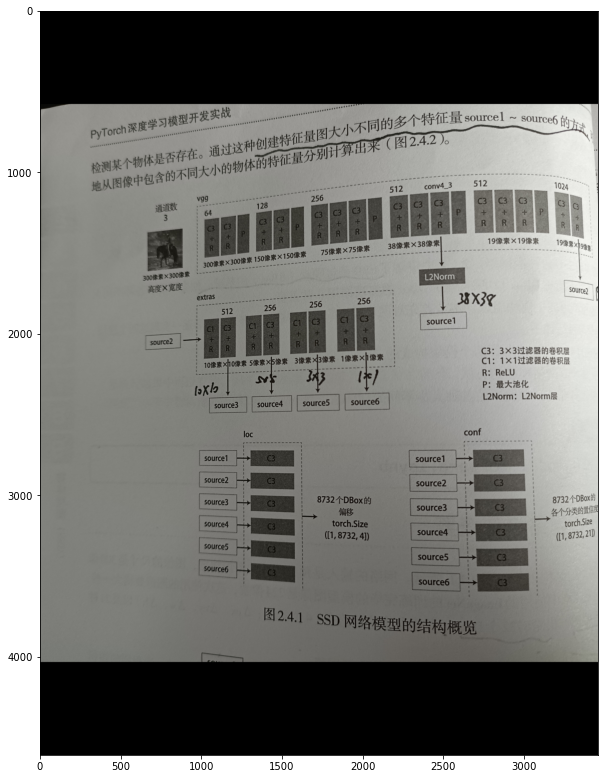

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

ssd_img_path = 'imgs/SSD网络模型的结构预览.jpg'
ssd_img = Image.open(ssd_img_path)
ssd_img = ssd_img.rotate(90)

plt.figure(figsize=(10, 20))
plt.imshow(ssd_img)
plt.show()

In [15]:
# SSD 类的实现
class SSD(nn.Module):
  
    def __init__(self, phase, cfg):
      super(SSD,self).__init__()
      
      self.phase = phase
      self.num_classes = cfg['num_classes']
      
      self.vgg = make_vgg()
      self.extras = make_extras()
      self.L2Norm = L2Norm()
      self.loc,self.conf = make_loc_conf()
      
      dbox = DBox(cfg)
      self.dbox_list = dbox.make_dbox_list()
      
      # 推测时候，使用 Detect()
      if phase == 'inference':
          self.detect = Detect()
    
    def forward(self,x):
        sources = list()
        loc = list()
        conf = list()
        
        for k in range(23):
            x = self.vgg[k](x)
        source1 = self.L2Norm(x)
        sources.append(source1)
        
        for k in range(23,len(self.vgg)):
            x = self.vgg[k](x) # source2
        sources.append(x)
        
        # 计算extras 的conv 和Relu
        # 并将 source3~source6添加到sources中
        for k,v in enumerate(self.extras):
            x = F.relu(v(x),inplace=True)
            if k %2 == 1:  # conv-relu-conv-relu放入sources中
                sources.append(x)
        
        # 对sorce1~source6分别进行一次卷积
        for (x,l,c) in zip(sources,self.loc,self.conf):
            # torch.contiguous()方法首先拷贝了一份张量在内存中的地址，然后将地址按照形状改变后的张量的语义进行排列。
            # torch.contiguous()方法语义上是“连续的”，经常与torch.permute()、torch.transpose()、torch.view()方法一起使用
            # 为了能够执行view()函数，对象的内存变量在内存中必须是连续存储的
            # touch.view()方法对张量改变“形状”其实并没有改变张量在内存中真正的形状，可以理解为：
            # ① view方法没有拷贝新的张量，没有开辟新内存，与原张量共享内存；
            # ② view方法只是重新定义了访问张量的规则，使得取出的张量按照我们希望的形状展现。
            loc.append(l(x).permute(0,2,3,1).contiguous())
            conf.append(c(x).permute(0,2,3,1).contiguous())
            
        # 对loc和conf变形，
        # loc的尺寸是torch.Size([batch_num,8732*4])
        # conf的尺寸是torch.Size([batch_num,8732*21])
        loc = torch.cat([o.view(o.size(0),-1) for o in loc],1)
        conf = torch.cat([o.view(o.size(0),-1) for o in conf],1)
        
        loc = loc.view(loc.size(0),-1,4) # [batch_num,8732,4]
        conf = conf.view(conf.size(0),-1,self.num_classes) # [batch_num,8732,21]
        
        output = (loc,conf,self.dbox_list)
        
        if self.phase == 'inference': # 预测模式
            return self.detect(output[0],output[1],output[2])
        
        else:
            return output
        
            
            